In [29]:
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rasterstats import zonal_stats, point_query
from shapely.geometry import box

In [ ]:
/Users/lbeuster/Documents/SAL/Projects/throwing_shade/results/output/vegetation_shade_tests/dsm_bldg_test/vegbldgtest/dsm_blg_veg_day.tif


/Users/lbeuster/Documents/SAL/Projects/throwing_shade/data/clean_data

In [3]:
verhardingen = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/Land_Surface_Temperature/data/raw_data/AMS/verhardingen/Q1_20230126_ingekort.gpkg')

In [31]:
with rasterio.open('../data/clean_data/shade_comparison/buildings_only/shadow_fraction_on_20240703.tif') as src:
    data = src.read(1)
    data_meta = src.meta.copy()
    data_crs = src.crs
    affine = src.transform
    # Get the bounding box
    bbox = src.bounds
    x_min, y_min, x_max, y_max = bbox.left, bbox.bottom, bbox.right, bbox.top

# Create a bounding box geometry
bbox_geom = box(x_min, y_min, x_max, y_max)

# Create a GeoDataFrame with the bounding box
bbox_gdf = gpd.GeoDataFrame({'geometry': bbox_geom}, index=[0], crs=src.crs)

verhardingen = gpd.read_file('/Users/lbeuster/Documents/TU Delft/Projects/Land_Surface_Temperature/data/raw_data/AMS/verhardingen/Q1_20230126_ingekort.gpkg', mask=bbox_gdf).to_crs(data_crs)

# Handle invalid/faulty geometries:
verhardingen.geometry = verhardingen.geometry.buffer(0)

verhardingen = gpd.clip(verhardingen, bbox_gdf)


In [25]:
verhardingen.explore()

In [23]:
verhardingen.head()

24     POLYGON ((627491.626 5804746.789, 627495.369 5...
25     POLYGON ((627502.857 5804740.172, 627503.685 5...
23     POLYGON ((627494.579 5804743.359, 627494.692 5...
240    POLYGON ((627511.920 5804744.432, 627512.004 5...
266    POLYGON ((627495.151 5804750.079, 627495.062 5...
dtype: geometry

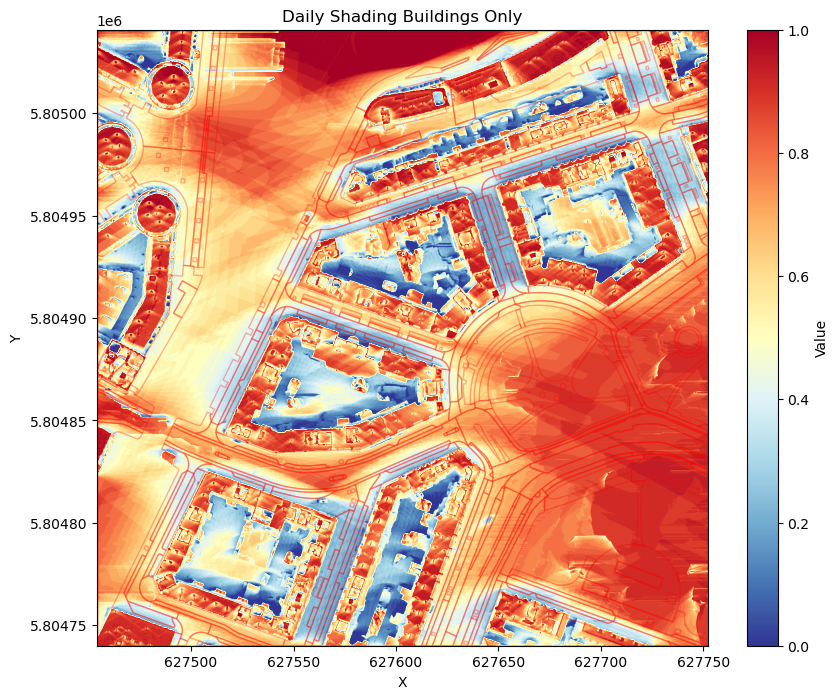

In [114]:
# Plot the combined raster
plt.figure(figsize=(10, 8))
plt.imshow(data, cmap='RdYlBu_r', extent=[x_min, x_max, y_min, y_max])
plt.title('Daily Shading Buildings Only')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the GeoDataFrame
verhardingen.plot(ax=plt.gca(), edgecolor='red', facecolor='none', alpha=0.3)
bbox_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

In [143]:
# Add an index column to the GeoDataFrame
verhardingen['index'] = verhardingen.index

# Convert GeoDataFrame to GeoJSON format
gdf_json = verhardingen.to_json()
print(gdf_json)


# Compute statistics using zonal_stats with already loaded data
stats = zonal_stats(gdf_json, data, affine=affine, nodata=src.nodata, stats=["mean", "median", "sum", "min", "max", "percentile_90"], geojson_out=True)
print(stats)

# Convert stats to a DataFrame
stats_df = pd.DataFrame([feature['properties'] for feature in stats])
print(stats_df.head())

# Merge the statistics back to the GeoDataFrame using the index
bldg_stats = verhardingen.merge(stats_df, left_on='index', right_on='index')

# Drop columns with _y suffix
bldg_stats = bldg_stats.drop(columns=[col for col in bldg_stats.columns if col.endswith('_y')])

# Rename columns with _x suffix
bldg_stats.columns = [col.replace('_x', '') for col in bldg_stats.columns]

# For binary raster data, compute the percentage covered by 1s
bldg_stats['area'] = bldg_stats['geometry'].area  # Compute the area of each polygon
bldg_stats['coverage'] = bldg_stats['sum'] / bldg_stats['area']  # Calculate coverage percentage

# Inspect the result
bldg_stats.head()

{"type": "FeatureCollection", "features": [{"id": "24", "type": "Feature", "properties": {"Guid": "{7A38E540-E4EF-4F34-9626-6798A88AB4D1}", "Objecttype": "Verhardingsobject", "Type": "Elementenverharding", "Type_gedetailleerd": "Straatbaksteen", "Type_extra_gedetailleerd": "Gebakken steen", "Kleur": "Rood", "Type_rijstrook": null, "Gebruiksfunctie": "Voetpad", "Wegtype_bestaand": "6 - Weg in verblijfsgebied", "Jaar_uitgevoerd_onderhoud": null, "Jaar_laatste_conservering": null, "Jaar_van_aanleg": 2022, "Oppervlakte_GIS": 315.933717500007, "Beheerder_gedetailleerd": "R&E_VOR_Verhardingen", "Onderhoudsplichtige": null, "index": 24}, "geometry": {"type": "Polygon", "coordinates": [[[627491.6260804919, 5804746.788694077], [627495.3694157166, 5804745.492637664], [627494.6915047743, 5804743.662501786], [627494.5794804714, 5804743.35867801], [627493.3245482394, 5804740.0], [627489.0988610081, 5804740.0], [627491.6260804919, 5804746.788694077]]]}}, {"id": "25", "type": "Feature", "properties":

Guid         Objecttype  \
0  {7A38E540-E4EF-4F34-9626-6798A88AB4D1}  Verhardingsobject   
1  {ACA417E9-4754-44B3-AFE4-69F8E8B33B6F}  Verhardingsobject   
2  {997FAAC5-FD83-4273-A8A1-24BDE1464C75}  Verhardingsobject   
3  {81D53B4E-3F89-4125-9749-B3B96D5BCEBA}  Verhardingsobject   
4  {D8F4AAFB-7496-4BD1-8ABC-D3B8ADBA5A15}  Verhardingsobject   

                  Type Type_gedetailleerd Type_extra_gedetailleerd  Kleur  \
0  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
1  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
2  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
3  Elementenverharding             Tegels               Betontegel  Grijs   
4  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   

  Type_rijstrook Gebruiksfunctie            Wegtype_bestaand  \
0           None         Voetpad  6 - Weg in verblijfsgebied   
1           None         Voetpad  6 - Weg in verblijfsgebied   
2           None         Rijbaan       5 - Weg in woongebied   
3           None         Voetpad  6 - Weg in verblijfsgebied   
4           None         Rijbaan       5 - Weg in woongebied   

   Jaar_uitgevoerd_onderhoud  ...  index   id       min       max      mean  \
0                        NaN  ...     24   24  0.264706  0.941176  0.487181   
1                        NaN  ...     25   25  0.176471  0.647059  0.371475   
2                        NaN  ...     23   23  0.441176  0.558824  0.502426   
3                     2010.0  ...    240  240  0.029412  0.823529  0.462460   
4                        NaN  ...    266  266  0.411765  0.735294  0.575800   

           sum    median percentile_90        area  coverage  
0   201.205872  0.411765      0.882353   25.960918  7.750337  
1    27.117645  0.382353      0.470588    4.507676  6.015881  
2    97.470596  0.500000      0.558824   12.109175  8.049318  
3   451.823547  0.500000      0.558824   61.521164  7.344197  
4  1137.205933  0.558824      0.676471  123.229429  9.228363  

[5 rows x 26 columns]

In [158]:
bldg_stats.explore(column="mean", cmap = 'RdYlBu_r', tiles="CartoDB positron")

In [43]:
with rasterio.open('../data/clean_data/shade_comparison/buildings_trees/veg_bldg_shade_day.tif') as src:
    bldtree = src.read(1)
    bldtree_meta = src.meta.copy()
    bldtree_crs = src.crs
    bldtree_affine = src.transform

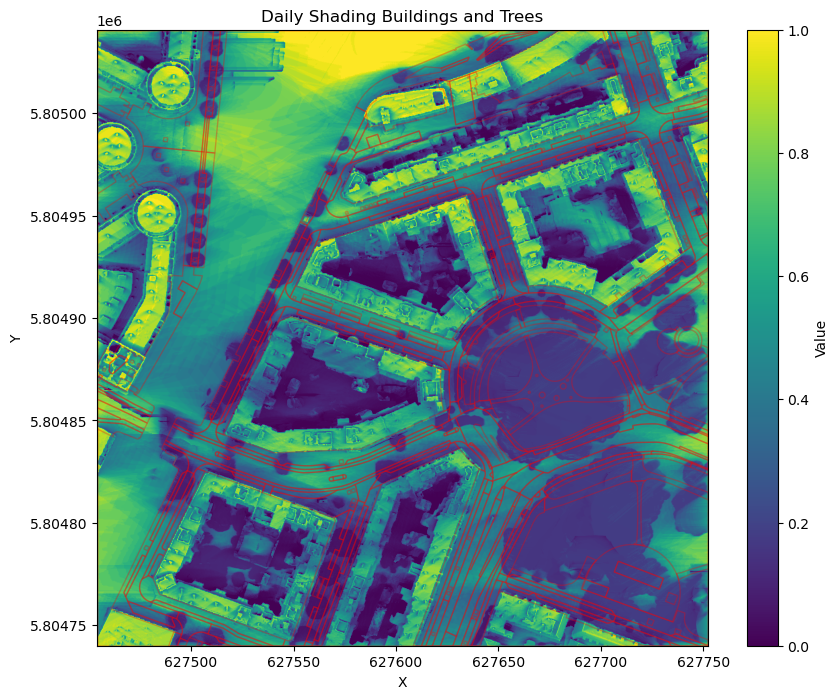

In [61]:
# Plot the combined raster
plt.figure(figsize=(10, 8))
plt.imshow(bldtree, cmap='viridis', extent=[x_min, x_max, y_min, y_max])
plt.title('Daily Shading Buildings and Trees')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the GeoDataFrame
verhardingen.plot(ax=plt.gca(), edgecolor='red', facecolor='none', alpha=0.3)
bbox_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

In [144]:
# Add an index column to the GeoDataFrame
verhardingen['index'] = verhardingen.index

# Convert GeoDataFrame to GeoJSON format
gdf_json = verhardingen.to_json()

# Compute statistics using zonal_stats with already loaded data
stats = zonal_stats(gdf_json, bldtree, affine=affine, nodata=src.nodata, stats=["mean", "median", "sum", "min", "max", "percentile_90"], geojson_out=True)

# Convert stats to a DataFrame
stats_df = pd.DataFrame([feature['properties'] for feature in stats])

# Merge the statistics back to the GeoDataFrame using the index
bldg_tree_stats = verhardingen.merge(stats_df, left_on='index', right_on='index')

# Drop columns with _y suffix
bldg_tree_stats = bldg_tree_stats.drop(columns=[col for col in bldg_tree_stats.columns if col.endswith('_y')])

# Rename columns with _x suffix
bldg_tree_stats.columns = [col.replace('_x', '') for col in bldg_tree_stats.columns]

# For binary raster data, compute the percentage covered by 1s - only relevant for hourly shade (1/0)
bldg_tree_stats['area'] = bldg_tree_stats['geometry'].area  # Compute the area of each polygon
bldg_tree_stats['coverage'] = bldg_tree_stats['sum'] / bldg_tree_stats['area']  # Calculate coverage percentage

bldg_tree_stats.rename(columns={"min": "min_tree", "max": "max_tree", "mean": "mean_tree", "sum": "sum_tree", "median": "median_tree", "percentile_90": "percentile_90_tree", "area": "area_tree", "coverage": "coverage_tree"}, inplace=True)

# Inspect the result
bldg_tree_stats.head()

Guid         Objecttype  \
0  {7A38E540-E4EF-4F34-9626-6798A88AB4D1}  Verhardingsobject   
1  {ACA417E9-4754-44B3-AFE4-69F8E8B33B6F}  Verhardingsobject   
2  {997FAAC5-FD83-4273-A8A1-24BDE1464C75}  Verhardingsobject   
3  {81D53B4E-3F89-4125-9749-B3B96D5BCEBA}  Verhardingsobject   
4  {D8F4AAFB-7496-4BD1-8ABC-D3B8ADBA5A15}  Verhardingsobject   

                  Type Type_gedetailleerd Type_extra_gedetailleerd  Kleur  \
0  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
1  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
2  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
3  Elementenverharding             Tegels               Betontegel  Grijs   
4  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   

  Type_rijstrook Gebruiksfunctie            Wegtype_bestaand  \
0           None         Voetpad  6 - Weg in verblijfsgebied   
1           None         Voetpad  6 - Weg in verblijfsgebied   
2           None         Rijbaan       5 - Weg in woongebied   
3           None         Voetpad  6 - Weg in verblijfsgebied   
4           None         Rijbaan       5 - Weg in woongebied   

   Jaar_uitgevoerd_onderhoud  ...  index   id  min_tree  max_tree mean_tree  \
0                        NaN  ...     24   24  0.076471  0.894118  0.297750   
1                        NaN  ...     25   25  0.129412  0.505882  0.238679   
2                        NaN  ...     23   23  0.088235  0.535294  0.285082   
3                     2010.0  ...    240  240  0.005882  0.588235  0.147474   
4                        NaN  ...    266  266  0.082353  0.735294  0.306612   

     sum_tree  median_tree percentile_90_tree   area_tree  coverage_tree  
0  122.970596     0.217647           0.858824   25.960918       4.736758  
1   17.423531     0.194118           0.411765    4.507676       3.865302  
2   55.305885     0.288235           0.511765   12.109175       4.567271  
3  144.082367     0.117647           0.220000   61.521164       2.341997  
4  605.558838     0.288235           0.580000  123.229429       4.914076  

[5 rows x 26 columns]

In [157]:
bldg_tree_stats.explore(column="median_tree", cmap = 'RdYlBu_r', tiles="CartoDB positron")

## Difference daily shade

In [148]:
merged = pd.merge(bldg_stats, bldg_tree_stats, on="Guid", how="left")

# Drop columns with _y suffix
merged = merged.drop(columns=[col for col in merged.columns if col.endswith('_y')])

# Rename columns with _x suffix
merged.columns = [col.replace('_x', '') for col in merged.columns]

In [149]:
merged.head()

Guid         Objecttype  \
0  {7A38E540-E4EF-4F34-9626-6798A88AB4D1}  Verhardingsobject   
1  {ACA417E9-4754-44B3-AFE4-69F8E8B33B6F}  Verhardingsobject   
2  {997FAAC5-FD83-4273-A8A1-24BDE1464C75}  Verhardingsobject   
3  {81D53B4E-3F89-4125-9749-B3B96D5BCEBA}  Verhardingsobject   
4  {D8F4AAFB-7496-4BD1-8ABC-D3B8ADBA5A15}  Verhardingsobject   

                  Type Type_gedetailleerd Type_extra_gedetailleerd  Kleur  \
0  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
1  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
2  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   
3  Elementenverharding             Tegels               Betontegel  Grijs   
4  Elementenverharding     Straatbaksteen           Gebakken steen   Rood   

  Type_rijstrook Gebruiksfunctie            Wegtype_bestaand  \
0           None         Voetpad  6 - Weg in verblijfsgebied   
1           None         Voetpad  6 - Weg in verblijfsgebied   
2           None         Rijbaan       5 - Weg in woongebied   
3           None         Voetpad  6 - Weg in verblijfsgebied   
4           None         Rijbaan       5 - Weg in woongebied   

   Jaar_uitgevoerd_onderhoud  ...        area  coverage  min_tree  max_tree  \
0                        NaN  ...   25.960918  7.750337  0.076471  0.894118   
1                        NaN  ...    4.507676  6.015881  0.129412  0.505882   
2                        NaN  ...   12.109175  8.049318  0.088235  0.535294   
3                     2010.0  ...   61.521164  7.344197  0.005882  0.588235   
4                        NaN  ...  123.229429  9.228363  0.082353  0.735294   

  mean_tree    sum_tree  median_tree percentile_90_tree   area_tree  \
0  0.297750  122.970596     0.217647           0.858824   25.960918   
1  0.238679   17.423531     0.194118           0.411765    4.507676   
2  0.285082   55.305885     0.288235           0.511765   12.109175   
3  0.147474  144.082367     0.117647           0.220000   61.521164   
4  0.306612  605.558838     0.288235           0.580000  123.229429   

   coverage_tree  
0       4.736758  
1       3.865302  
2       4.567271  
3       2.341997  
4       4.914076  

[5 rows x 34 columns]

In [159]:
merged['difference'] = merged['median'] - merged['median_tree']
merged.explore(column='difference', cmap='YlGnBu', tiles="CartoDB positron")

## Hourly shade

School hours:
- start: 8:30-9:00
- Lunch break: 11:45-12:30 ish
- end: 14:00-15:30

Most important shade time:

- 12:00

- 15:00 / 16:00;

Hypothesis: I'd assume that buildings play a bigger role in the afternoon


In [64]:
with rasterio.open('../data/clean_data/shade_comparison/buildings_only/Shadow_20240703_1200_LST.tif') as src:
    lunchbld = src.read(1)
    lunchbld_meta = src.meta.copy()
    lunchbld_crs = src.crs
    lunchbld_affine = src.transform

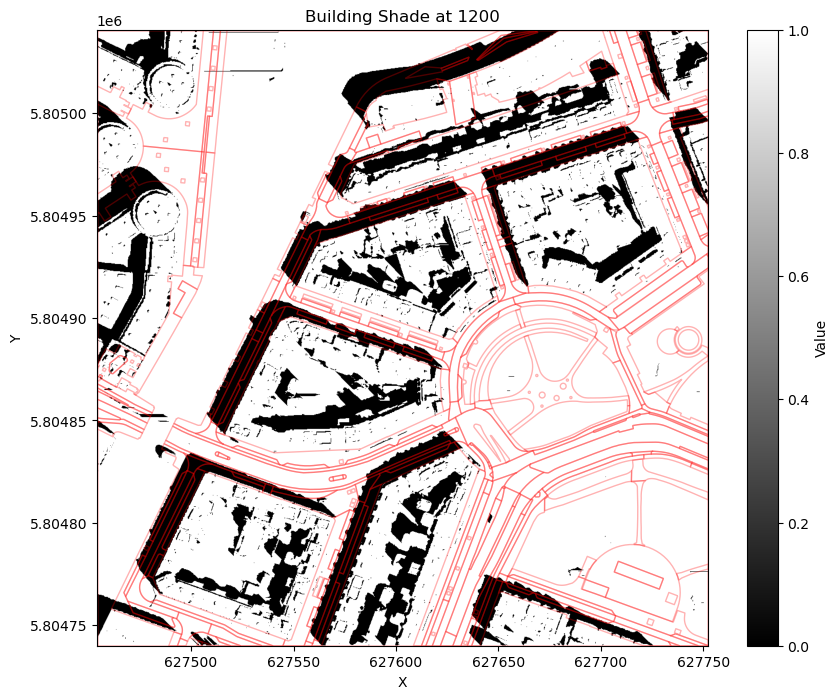

In [90]:
# Plot the combined raster
plt.figure(figsize=(10, 8))
plt.imshow(lunchbld, cmap='gray', extent=[x_min, x_max, y_min, y_max])
plt.title('Building Shade at 1200')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the GeoDataFrame
verhardingen.plot(ax=plt.gca(), edgecolor='red', facecolor='none', alpha=0.3)
bbox_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

In [67]:
with rasterio.open('../data/clean_data/shade_comparison/buildings_trees/Shadow_20240703_1200_LST.tif') as src:
    lunchbldtree = src.read(1)
    lunchbldtree_meta = src.meta.copy()
    lunchbldtree_crs = src.crs
    lunchbldtree_affine = src.transform

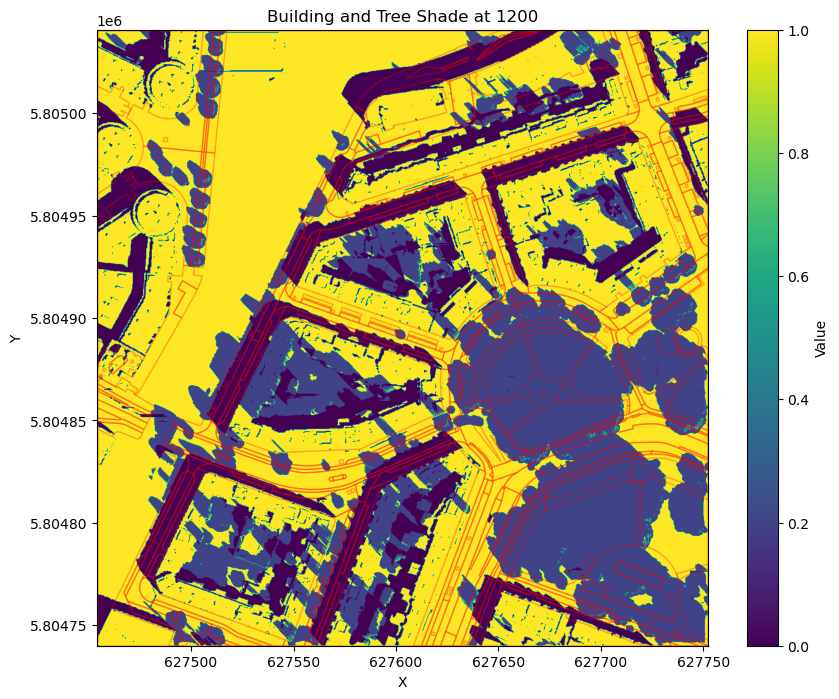

In [88]:
with rasterio.open('../data/clean_data/shade_comparison/buildings_trees/Shadow_20240703_1200_LST.tif') as src:
    lunchbldtree = src.read(1)
    lunchbldtree_meta = src.meta.copy()
    lunchbldtree_crs = src.crs
    lunchbldtree_affine = src.transform

# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(lunchbldtree, cmap='viridis', extent=[x_min, x_max, y_min, y_max])
plt.title('Building and Tree Shade at 1200')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the GGDF
verhardingen.plot(ax=plt.gca(), edgecolor='red', facecolor='none', alpha=0.3)
bbox_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

Converting to absolute shade yes/no

In [97]:
# Set all values < 1.0 to 0
lunchbldtree[lunchbldtree < 1.0] = 0

# Invert the binary values: 0 becomes 1 and 1 becomes 0
lunchbldtree = np.where(lunchbldtree == 0, 1, 0)

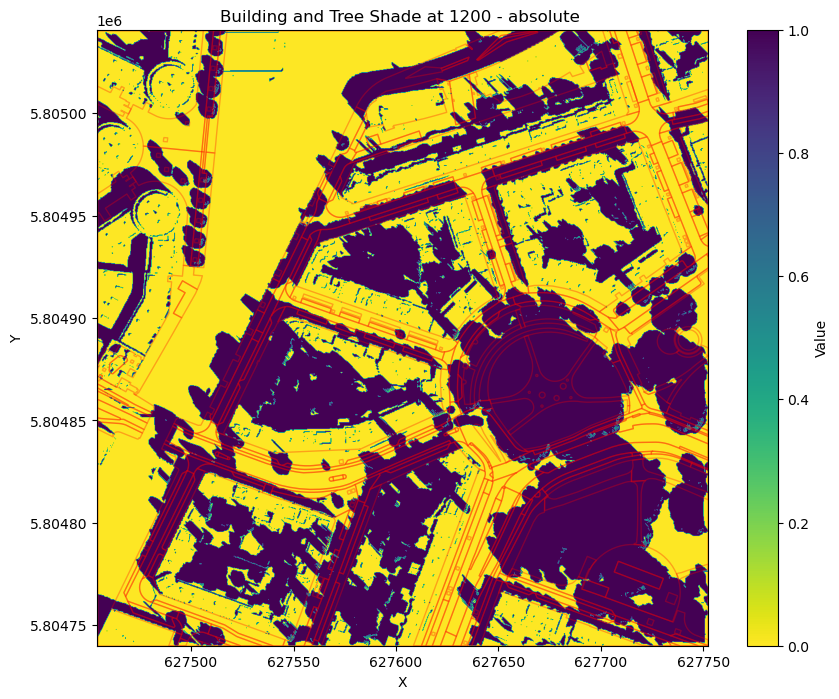

In [111]:
# Plot the raster
plt.figure(figsize=(10, 8))
plt.imshow(lunchbldtree, cmap='viridis_r', extent=[x_min, x_max, y_min, y_max])
plt.title('Building and Tree Shade at 1200 - absolute ')
plt.colorbar(label='Value')
plt.xlabel('X')
plt.ylabel('Y')

# Plot the GGDF
verhardingen.plot(ax=plt.gca(), edgecolor='red', facecolor='none', alpha=0.3)
bbox_gdf.plot(ax=plt.gca(), edgecolor='red', facecolor='none')

plt.show()

In [127]:
# Add an index column to the GeoDataFrame
verhardingen['index'] = verhardingen.index

# Convert GeoDataFrame to GeoJSON format
gdf_json = verhardingen.to_json()

# Compute statistics using zonal_stats with already loaded data
stats = zonal_stats(gdf_json, lunchbldtree, affine=affine, nodata=src.nodata, stats=["mean", "median", "sum", "min", "max", "percentile_90"], geojson_out=True)

# Convert stats to a DataFrame
stats_df = pd.DataFrame([feature['properties'] for feature in stats])


# Merge the statistics back to the GeoDataFrame using the index
lunchbldtree_stats = verhardingen.merge(stats_df, left_on='index', right_on='index')

# For binary raster data, compute the percentage covered by 1s - only relevant for hourly shade (1/0)
lunchbldtree_stats['area'] = lunchbldtree_stats['geometry'].area  # Compute the area of each polygon
lunchbldtree_stats['coverage'] = lunchbldtree_stats['sum'] / (lunchbldtree_stats['area']/0.25)  # Calculate coverage percentage divided by resolution

lunchbldtree_stats.rename(columns={"min": "min_tree", "max": "max_tree", "mean": "mean_tree", "sum": "sum_tree", "median": "median_tree", "percentile_90": "percentile_90_tree", "area": "area_tree", "coverage": "coverage_tree"}, inplace=True)

# Inspect the result
lunchbldtree_stats.head()

Guid_x       Objecttype_x  \
0  {7A38E540-E4EF-4F34-9626-6798A88AB4D1}  Verhardingsobject   
1  {ACA417E9-4754-44B3-AFE4-69F8E8B33B6F}  Verhardingsobject   
2  {997FAAC5-FD83-4273-A8A1-24BDE1464C75}  Verhardingsobject   
3  {81D53B4E-3F89-4125-9749-B3B96D5BCEBA}  Verhardingsobject   
4  {D8F4AAFB-7496-4BD1-8ABC-D3B8ADBA5A15}  Verhardingsobject   

                Type_x Type_gedetailleerd_x Type_extra_gedetailleerd_x  \
0  Elementenverharding       Straatbaksteen             Gebakken steen   
1  Elementenverharding       Straatbaksteen             Gebakken steen   
2  Elementenverharding       Straatbaksteen             Gebakken steen   
3  Elementenverharding               Tegels                 Betontegel   
4  Elementenverharding       Straatbaksteen             Gebakken steen   

  Kleur_x Type_rijstrook_x Gebruiksfunctie_x          Wegtype_bestaand_x  \
0    Rood             None           Voetpad  6 - Weg in verblijfsgebied   
1    Rood             None           Voetpad  6 - Weg in verblijfsgebied   
2    Rood             None           Rijbaan       5 - Weg in woongebied   
3   Grijs             None           Voetpad  6 - Weg in verblijfsgebied   
4    Rood             None           Rijbaan       5 - Weg in woongebied   

   Jaar_uitgevoerd_onderhoud_x  ...  Beheerder_gedetailleerd_y  \
0                          NaN  ...       R&E_VOR_Verhardingen   
1                          NaN  ...       R&E_VOR_Verhardingen   
2                          NaN  ...       R&E_VOR_Verhardingen   
3                       2010.0  ...       R&E_VOR_Verhardingen   
4                          NaN  ...       R&E_VOR_Verhardingen   

   Onderhoudsplichtige_y  min_tree max_tree mean_tree sum_tree  median_tree  \
0                   None       0.0      1.0  0.646489    267.0          1.0   
1                   None       0.0      1.0  0.602740     44.0          1.0   
2                   None       0.0      1.0  0.340206     66.0          0.0   
3                   None       0.0      1.0  0.875128    855.0          1.0   
4                   None       0.0      1.0  0.581266   1148.0          1.0   

  percentile_90_tree   area_tree coverage_tree  
0                1.0   25.960918      2.571173  
1                1.0    4.507676      2.440282  
2                1.0   12.109175      1.362603  
3                1.0   61.521164      3.474414  
4                1.0  123.229429      2.328989  

[5 rows x 41 columns]

In [134]:
lunchbldtree_stats.explore(column="coverage_tree", cmap = 'RdYlBu_r')